In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define the class and subclass names
class_names = ['Cofield','Tornier','Zimmer','Depuy']

# Initialize empty lists to store the image paths and labels
X_train = []
y_class_train = []
X_val = []
y_class_val = []
X_test = []
y_class_test = []


# Loop through each class and subclass folder and append the image paths and labels to the lists
for i, class_name in enumerate(class_names):
  # Get the train image paths and labels
  train_image_paths = tf.io.gfile.glob('/content/drive/MyDrive/dataset/' + '/train/' + class_name + '/*.jpg')
  train_class_labels = [i] * len(train_image_paths)
  X_train.extend(train_image_paths)
  y_class_train.extend(train_class_labels)
  # Get the val image paths and labels
  val_image_paths = tf.io.gfile.glob('/content/drive/MyDrive/dataset/' + '/val/' + class_name + '/*.jpg')
  val_class_labels = [i] * len(val_image_paths)
  X_val.extend(val_image_paths)
  y_class_val.extend(val_class_labels)
  # Get the test image paths and labels
  test_image_paths = tf.io.gfile.glob('/content/drive/MyDrive/dataset/' + '/test/' + class_name + '/*.jpg')
  test_class_labels = [i] * len(test_image_paths)
  X_test.extend(test_image_paths)
  y_class_test.extend(test_class_labels)


In [ ]:
# Print the class names and their shape
print("Class names:", class_names)
print("Shape of class names:", np.array(class_names).shape)


# Print the shapes of the training, validation, and test datasets
print("Shape of X_train:", np.array(X_train).shape)
print("Shape of y_class_train:", np.array(y_class_train).shape)
print("Shape of X_val:", np.array(X_val).shape)
print("Shape of y_class_val:", np.array(y_class_val).shape)
print("Shape of X_test:", np.array(X_test).shape)
print("Shape of y_class_test:", np.array(y_class_test).shape)


Class names: ['Cofield', 'Tornier', 'Zimmer', 'Depuy']
Shape of class names: (4,)
Shape of X_train: (477,)
Shape of y_class_train: (477,)
Shape of X_val: (58,)
Shape of y_class_val: (58,)
Shape of X_test: (62,)
Shape of y_class_test: (62,)


In [ ]:
# Convert the lists to arrays
X_train = np.array(X_train)
y_class_train = np.array(y_class_train)
X_val = np.array(X_val)
y_class_val = np.array(y_class_val)
X_test = np.array(X_test)
y_class_test = np.array(y_class_test)

In [ ]:
# Define some parameters
input_shape = (180, 180, 3)  # Example input image dimensions
num_classes = 4  # Number of fruit classes
#buffer_size = 2000 # Size of the shuffle buffer
batch_size = 32  # Size of the batches

# Define a helper function to load, decode, resize, and normalize an image from a given path
def load_image(path, input_shape):
    # Read the file
    image = tf.io.read_file(path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image to the specified input shape
    image = tf.image.resize(image, input_shape[:2])
    # Normalize the image to the range [0, 1]
    image = image / 255.0
    return image

In [ ]:
import tensorflow as tf

# Define a helper function to encode labels as one-hot vectors
def encode_label(class_label, num_classes):
    class_label = tf.one_hot(class_label, num_classes)  # Encode the class label
    return class_label


In [ ]:
# Define a function to create a dataset
def create_dataset(image_paths, class_labels, input_shape, num_classes,batch_size):
    # Create a dataset from the image paths and labels
    dataset1 = tf.data.Dataset.from_tensor_slices((image_paths, class_labels))

    # Map the function to load and preprocess the images
    dataset1 = dataset1.map(lambda x, y_class: (load_image(x, input_shape), encode_label(y_class, num_classes)))

    # Shuffle, batch, and prefetch the dataset
    dataset1 = dataset1.shuffle(buffer_size=300)  # Adjust buffer_size as needed
    dataset1 = dataset1.batch(batch_size)
    dataset1 = dataset1.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset1

# Create the train, val, and test datasets using the create_dataset function
train_dataset = create_dataset(X_train, y_class_train, input_shape, num_classes, batch_size)
val_dataset = create_dataset(X_val, y_class_val, input_shape, num_classes, batch_size)
test_dataset = create_dataset(X_test, y_class_test, input_shape, num_classes, batch_size)


In [ ]:
# Import the Keras preprocessing layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, RandomContrast

# Define some data augmentation parameters
flip_mode = "horizontal_and_vertical" # Flip the images horizontally and vertically
rotation_range = 0.2 # Rotate the images randomly within 20 degrees
crop_height = 180 # Crop the images to 200 pixels height
crop_width = 180 # Crop the images to 200 pixels width
contrast_factor = 0.4 # Adjust the contrast of the images randomly by 20%

# Create a data augmentation layer with the Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    RandomFlip(flip_mode, input_shape=input_shape),
    RandomRotation(rotation_range),
    RandomCrop(crop_height, crop_width),
    RandomContrast(contrast_factor)
])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Define the Squeeze-and-Excitation class
class SqueezeExcitation(tf.keras.layers.Layer):
    def __init__(self, channels, ratio=16, **kwargs):
        super(SqueezeExcitation, self).__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
        self.reduction = ratio  # This should be self.ratio

    def build(self, input_shape):
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.fc1 = tf.keras.layers.Dense(self.channels // self.reduction, activation='relu', use_bias=False)
        self.fc2 = tf.keras.layers.Dense(self.channels, activation='sigmoid', use_bias=False)

    def call(self, inputs):
        x = self.avg_pool(inputs)
        x = self.fc1(x)
        x = self.fc2(x)
        x = tf.keras.layers.Reshape((1, 1, self.channels))(x)
        return inputs * x

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax,SGD,Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPooling2D

# Load the DenseNet121 model, pretrained on ImageNet
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

x = base_model.output
x = SqueezeExcitation(channels=x.shape[-1])(x)  # Add the SE block here
x = tf.keras.layers.Dropout(0.4)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='selu')(x)
# Add dropout layer for reducing overfitting
x = tf.keras.layers.Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers[:20]:
    layer.trainable = False

model = tf.keras.Sequential([data_augmentation, model])
# Compile the model
model.compile(optimizer=SGD(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Print model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 model_1 (Functional)        (None, 4)                 7695428   
                                                                 
Total params: 7695428 (29.36 MB)
Trainable params: 7507204 (28.64 MB)
Non-trainable params: 188224 (735.25 KB)
_________________________________________________________________


In [ ]:
# import os
# from PIL import Image

# # Loop through each class and subclass folder and append the image paths and labels to the lists
# for i, class_name in enumerate(class_names):
#   # Define the directories
#   train_dir = '/content/drive/MyDrive/dataset/train/' + class_name
#   val_dir = '/content/drive/MyDrive/dataset/val/' + class_name
#   test_dir = '/content/drive/MyDrive/dataset/test/' + class_name

#   # Check each directory
#   for directory in [train_dir, val_dir, test_dir]:
#     for filename in os.listdir(directory):
#       if filename.endswith(".jpg"):
#         try:
#           img = Image.open(os.path.join(directory, filename))  # open the image file
#           img.verify()  # verify that it is, in fact, an image
#         except (IOError, SyntaxError) as e:
#           print('Bad file:', filename)  # print out the names of corrupt files


In [ ]:
# Train the model
epochs = 100  # Example number of epochs
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    validation_freq=1)  # Validate after each epoch

import pickle
with open('/content/drive/MyDrive/Model1/densenet.pkl', 'wb') as f:
    pickle.dump(history.history, f)

from keras.models import load_model
model.save("/content/drive/MyDrive/Model1/densenet.h5")

Epoch 1/100
15/15 [==============================] - 39s 564ms/step - loss: 1.4204 - accuracy: 0.4214 - val_loss: 1.3187 - val_accuracy: 0.3448
Epoch 2/100
15/15 [==============================] - 5s 292ms/step - loss: 1.3468 - accuracy: 0.4738 - val_loss: 1.3622 - val_accuracy: 0.3621
Epoch 3/100
15/15 [==============================] - 5s 301ms/step - loss: 1.2502 - accuracy: 0.4696 - val_loss: 1.2885 - val_accuracy: 0.3966
Epoch 4/100
15/15 [==============================] - 5s 294ms/step - loss: 1.1627 - accuracy: 0.5325 - val_loss: 0.9879 - val_accuracy: 0.5690
Epoch 5/100
15/15 [==============================] - 5s 309ms/step - loss: 1.1015 - accuracy: 0.5535 - val_loss: 1.0144 - val_accuracy: 0.5000
Epoch 6/100
15/15 [==============================] - 5s 297ms/step - loss: 1.0081 - accuracy: 0.5765 - val_loss: 0.9120 - val_accuracy: 0.6552
Epoch 7/100
15/15 [==============================] - 5s 287ms/step - loss: 0.9537 - accuracy: 0.6143 - val_loss: 1.0291 - val_accuracy: 0.500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.utils import custom_object_scope

# Define your SqueezeExcitation layer here or import it if it's defined in another file

with custom_object_scope({'SqueezeExcitation': SqueezeExcitation}):
    loaded_model = load_model("/content/drive/MyDrive/Model1/densenet.h5")

In [ ]:
# Load the history object from a file
import pickle
with open('/content/drive/MyDrive/Model1/densenet.pkl', 'rb') as f:
    history = pickle.load(f)



In [ ]:
# Display train results
result = loaded_model.evaluate(train_dataset)
print('Train Loss for class output:', result[0])
print('Train Accuracy for class output:', result[1])

# Test the model
results = loaded_model.evaluate(test_dataset)
print('Test loss for class output:', results[0])
print('Test accuracy for class output:', results[1])

results = loaded_model.evaluate(val_dataset)
print('val loss for class output:', results[0])
print('val accuracy for class output:', results[1])

15/15 [==============================] - 5s 89ms/step - loss: 0.0322 - accuracy: 0.9937
Train Loss for class output: 0.03220096975564957
Train Accuracy for class output: 0.9937106966972351
2/2 [==============================] - 0s 79ms/step - loss: 0.2031 - accuracy: 0.9355
Test loss for class output: 0.20312340557575226
Test accuracy for class output: 0.9354838728904724
2/2 [==============================] - 0s 69ms/step - loss: 0.7407 - accuracy: 0.8793
val loss for class output: 0.7407392859458923
val accuracy for class output: 0.8793103694915771


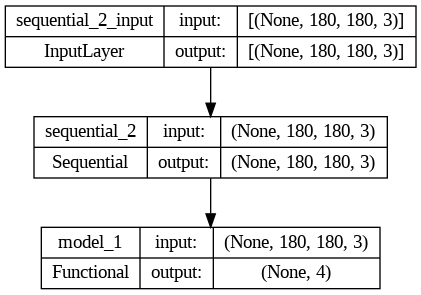

In [ ]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(loaded_model, to_file='model.png', show_shapes=True, show_layer_names=True)

Text(0.5, 1.0, 'Loss curves')

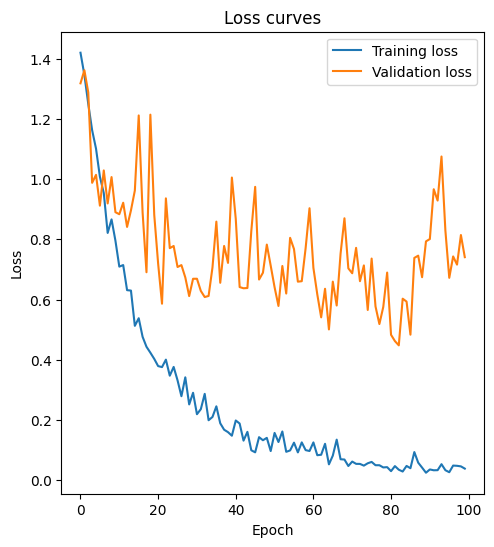

In [ ]:
# Plot the learning curves
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

# Access the history dictionary directly
plt.plot(history['loss'], label='Training loss')
plt.plot(history['val_loss'], label='Validation loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')


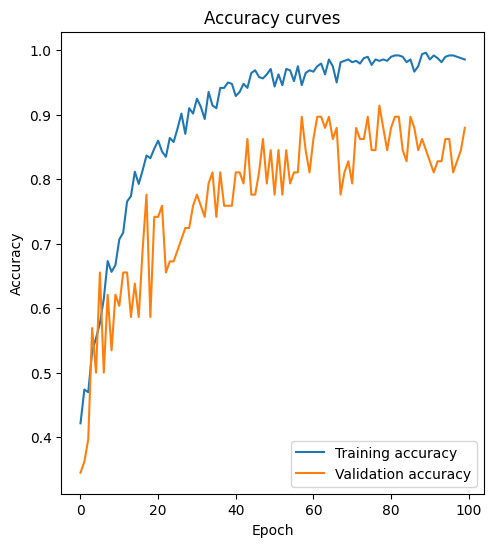

In [ ]:
plt.figure(figsize=(12, 6))

# Plot accuracy curves
plt.subplot(1, 2, 2)  # We already have loss curves on subplot 1
plt.plot(history['accuracy'], label='Training accuracy')
plt.plot(history['val_accuracy'], label='Validation accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy curves')

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data if necessary
if len(X_test.shape) == 1:
    X_test = np.array([load_image(path, input_shape) for path in X_test])

# predictions for the test set
y_pred_class = loaded_model.predict(X_test)

#Convert one-hot encoded labels back to class indices
y_class_true = np.argmax(y_class_test, axis=1) if len(y_class_test.shape) > 1 else y_class_test
y_class_pred = np.argmax(y_pred_class, axis=1)

# Calculate accuracy
class_accuracy = accuracy_score(y_class_true, y_class_pred)

#classification reports
class_report = classification_report(y_class_true, y_class_pred, target_names=class_names)
print("Class Accuracy:", class_accuracy)
print("\nClass Classification Report:")
print(class_report)


2/2 [==============================] - 2s 89ms/step
Class Accuracy: 0.9354838709677419

Class Classification Report:
              precision    recall  f1-score   support

     Cofield       0.80      0.89      0.84         9
     Tornier       1.00      1.00      1.00         8
      Zimmer       0.87      0.87      0.87        15
       Depuy       1.00      0.97      0.98        30

    accuracy                           0.94        62
   macro avg       0.92      0.93      0.92        62
weighted avg       0.94      0.94      0.94        62



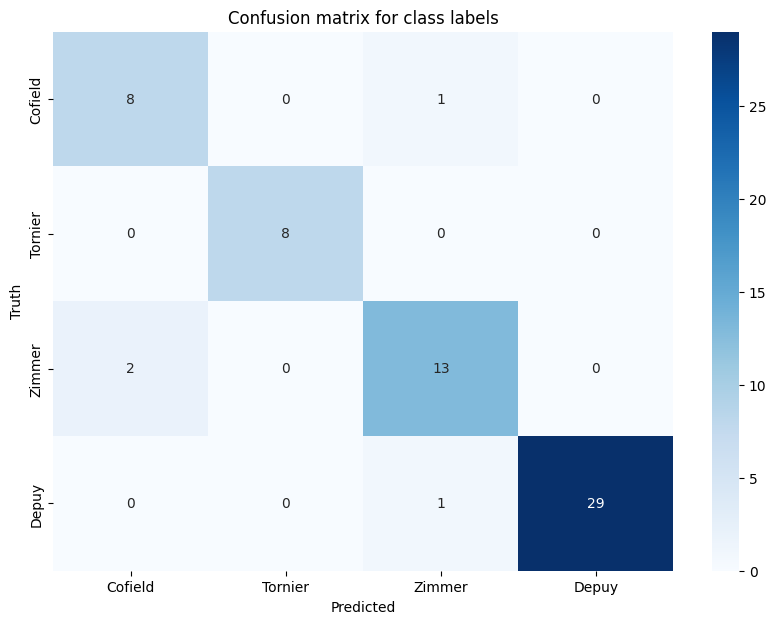

In [ ]:
# Compute the confusion matrix for the class labels
cm_class = confusion_matrix(y_class_true, y_class_pred)

# Now you can plot the confusion matrix using seaborn as before, but now the labels will be the class names:
plt.figure(figsize=(10,7))
sns.heatmap(cm_class, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names,cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion matrix for class labels')
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_class_true, y_class_pred, average='weighted')
recall = recall_score(y_class_true, y_class_pred, average='weighted')
f1 = f1_score(y_class_true, y_class_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.9387096774193548
Recall: 0.9354838709677419
F1-score: 0.9366205289056431
